In [1]:
import argparse
import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader

from multissl.data import SemiSupervisedSegmentationDataset,SegmentationDataset, semi_supervised_collate_fn
from multissl.plotting.false_color import visualize_batch_semi , visualize_predictions
from multissl.models import MeanTeacherSegmentationModel
from multissl.data.seg_transforms import create_mean_teacher_augmentations

In [2]:
CONFIG = {
    # Dataset parameters
    "img_dir": "../dataset/vineseg/imgs",  # Update with your path
    "mask_dir": "../dataset/vineseg/masks",  # Update with your path
    "unlabeled_dir": ["../dataset/vineseg/imgs/train_qbaixo5","../dataset/vineseg/imgs/train_valdoeiro5",  ],  # Optional path or list of paths to unlabeled images
    "img_size": 224,
    "batch_size": 8,
    "num_workers": 0,
    
    # Model parameters
    "pretrained_checkpoint": "../checkpoints_512_r18_view4_v2/last.ckpt",
    "backbone_type": "resnet18",  # Options: resnet18, resnet50, vit-s, swin-tiny
    "num_classes": 2,
    "in_channels": 4,  # 4 channels for R+G+RE+NIR
    "hidden_dim": 256,
    
    # Training parameters
    "epochs": 100,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "consistency_weight": 1.0,
    "consistency_rampup": 10,  # Epochs for ramping up consistency weight
    "check_val_every_n_epoch": 5,  # Validate every N epochs
    
    # Domain adaptation parameters
    "unfreeze_backbone_after": None,  # Unfreeze backbone after this many epochs (None to keep frozen)
    
    # Misc
    "seed": 42,
    "class_names": ["Background", "Vines"],  # Update with your class names
    "checkpoint_dir": "domain_adaptive_checkpoints",
    "project_name": "DomainAdaptiveSegmentation",
    "class_names": ["Background","Vines"],  # Update with your class names
    "class_weights": [0.5,1.0],

    "aug_p": 0.3, # heavyness of augments for the mean teacher,
    "ema_decay": 0.999,
    "confidence_threshold": 0.8
}

In [6]:
# Create augmentation transforms
supervised_transforms = create_mean_teacher_augmentations(
    img_size=CONFIG["img_size"], 
    in_channels=CONFIG["in_channels"],
    strong_aug_p=CONFIG["aug_p"],
    supervised=True
)

In [7]:
# Create train/val/test datasets
pl.seed_everything(CONFIG["seed"])

train_dataset = SemiSupervisedSegmentationDataset(
        img_dir=os.path.join(CONFIG["img_dir"], "train5"),
        mask_dir=os.path.join(CONFIG["mask_dir"], "train5"),
        unlabeled_dir=CONFIG["unlabeled_dir"],
        img_size=CONFIG["img_size"],
        transform = supervised_transforms,
        strong_aug_p = CONFIG["aug_p"],
        supervised_mode = True
    )


test_dataset_e = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "val_esac2"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "val_esac2"),
    img_size=CONFIG["img_size"]
)

test_dataset_v = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_valdoeiro"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_valdoeiro"),
    img_size=CONFIG["img_size"]
)

test_dataset_q = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_qbaixo"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_qbaixo"),
    img_size=CONFIG["img_size"]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True,
    collate_fn = semi_supervised_collate_fn
)

val_loader = DataLoader(
        test_dataset_e,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        num_workers=CONFIG["num_workers"],
        pin_memory=True
    )


test_loader_e = DataLoader(
    test_dataset_e,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

test_loader_v = DataLoader(
    test_dataset_v,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)
test_loader_q = DataLoader(
    test_dataset_q,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)
# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(test_dataset_e)}")
print(f"Test dataset size valdoeiro: {len(test_dataset_v)}")
print(f"Test dataset size qbaixo: {len(test_dataset_q)}")

Seed set to 42


Dataset composition:
  - Labeled images: 5
  - Unlabeled images: 10
  - Total: 15
  - Mode: Supervised
Train dataset size: 15
Validation dataset size: 97
Test dataset size valdoeiro: 158
Test dataset size qbaixo: 142


c:\users\judoj\documents\programming\multi_ssl\multissl\plotting\false_color.py:227: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


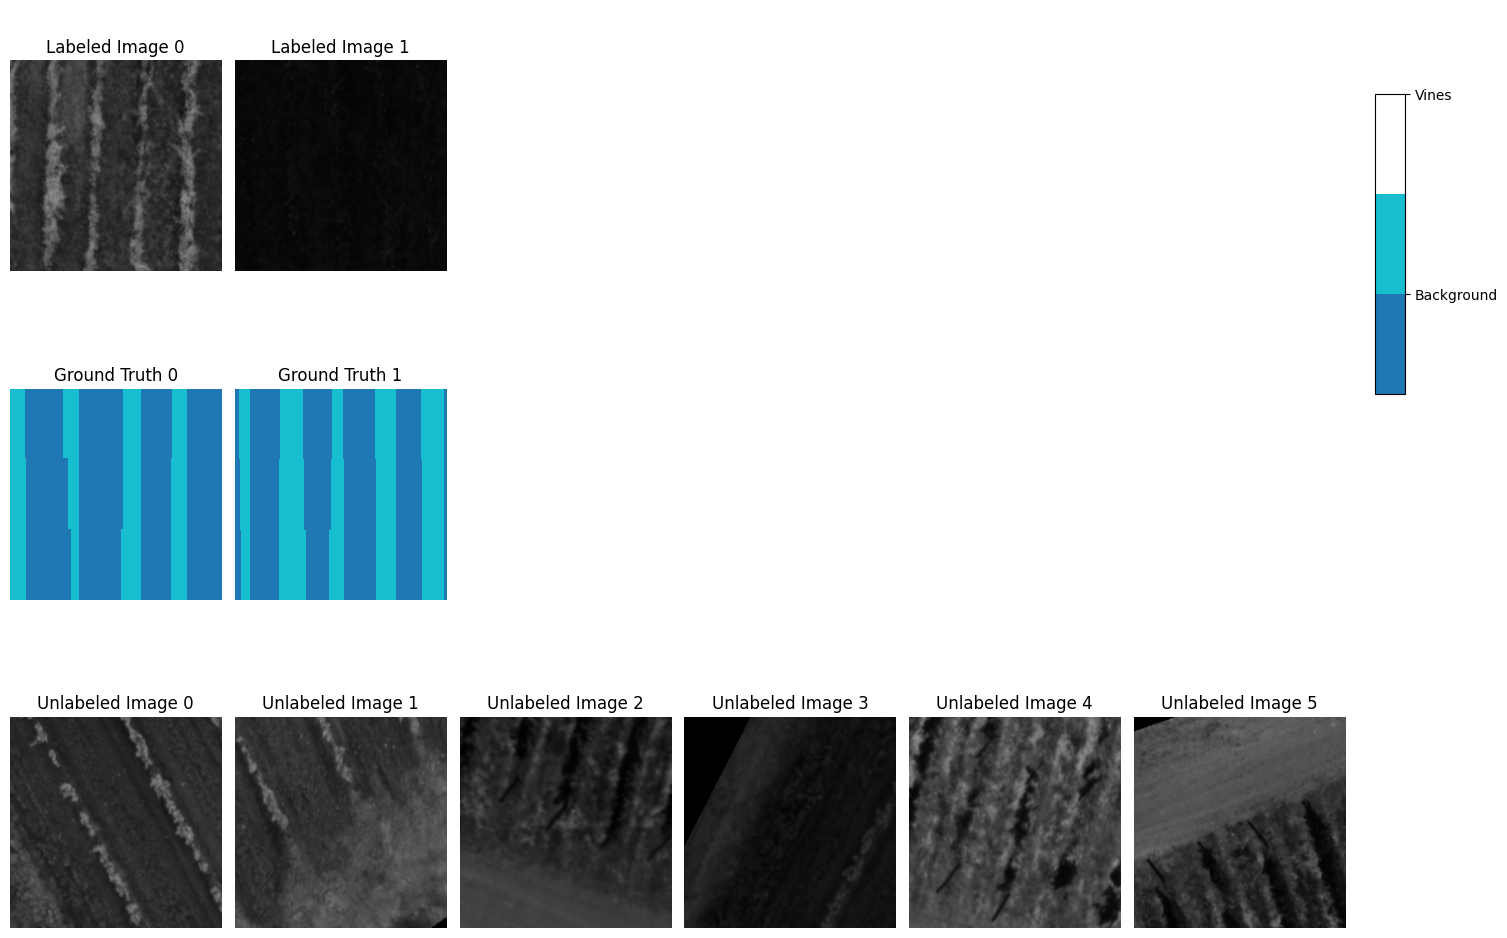

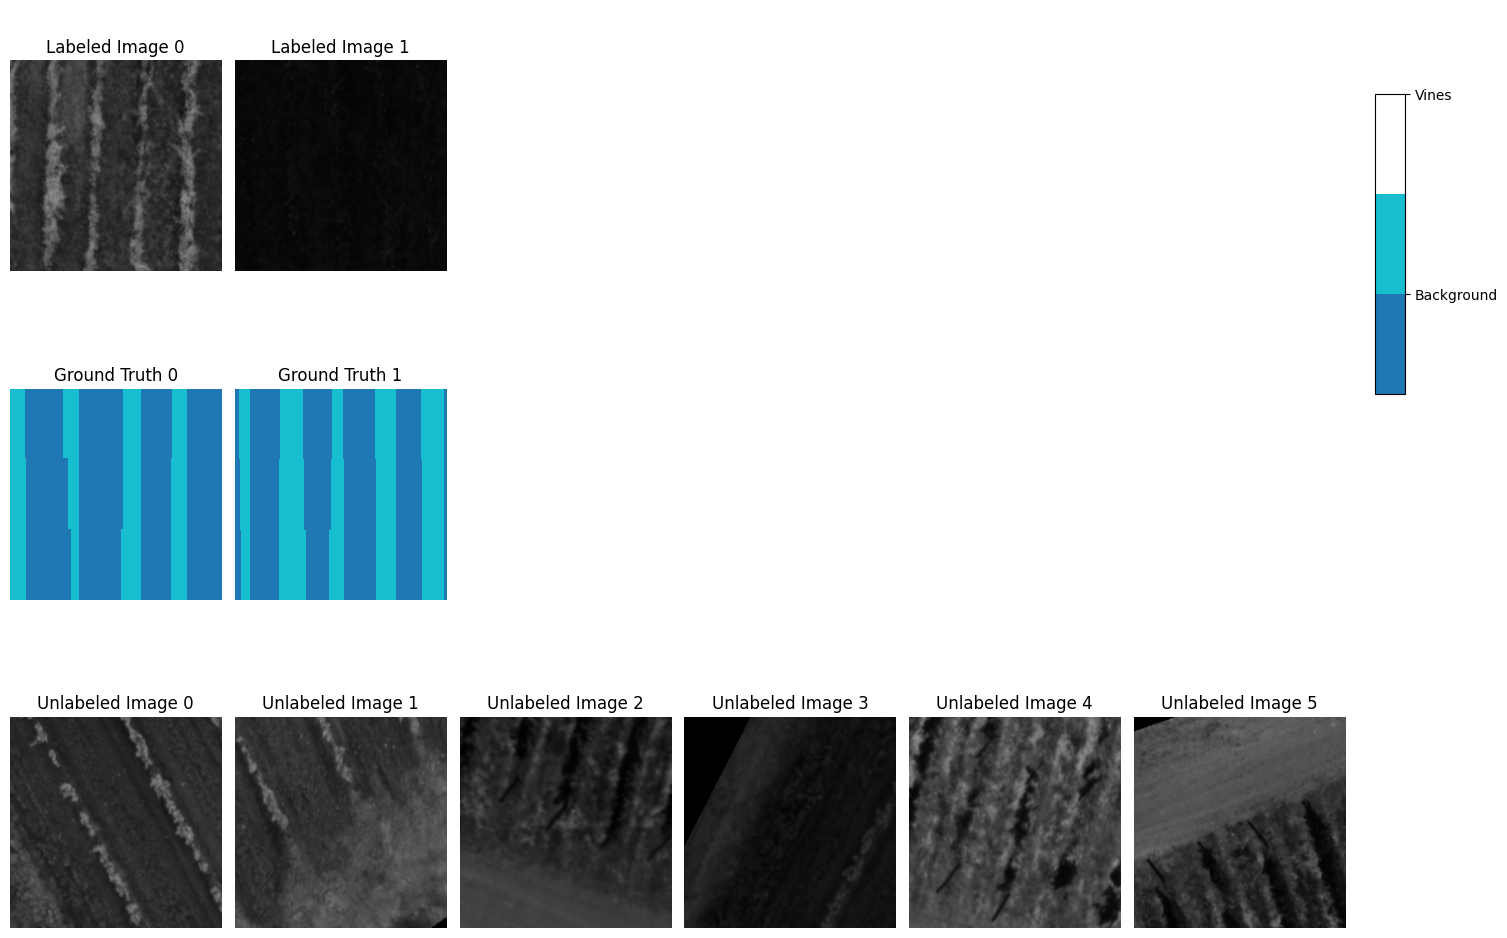

In [8]:
# Visualize a batch of training data
batch = next(iter(train_loader))
visualize_batch_semi(
    batch, 
    num_samples=15, 
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

In [18]:
# For ResNet50 pretrained with FastSiam
model = MeanTeacherSegmentationModel(
        backbone_type=CONFIG["backbone_type"],
        pretrained_path=CONFIG["pretrained_checkpoint"],
        in_channels=CONFIG["in_channels"],
        num_classes=CONFIG["num_classes"],
        img_size=CONFIG["img_size"],
        lr=CONFIG["lr"],
        weight_decay=CONFIG["weight_decay"],
        consistency_weight=CONFIG["consistency_weight"],
        consistency_rampup=CONFIG["consistency_rampup"],
        ema_decay=CONFIG["ema_decay"],  # Default EMA decay rate
        class_weights=CONFIG["class_weights"],
        confidence_threshold=CONFIG["confidence_threshold"]  # Default confidence threshold for pseudo-labels
    )

Detected feature dimensions: layer1=64, layer2=128, layer3=256, layer4=512


In [19]:
# Create callbacks
from pytorch_lightning.callbacks import RichProgressBar

checkpoint_callback = ModelCheckpoint(
    dirpath="segmentation_checkpoints",
    filename="r18_semi_teacher-{epoch:02d}-{val_loss:.4f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    save_last=True
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
# Create logger (you can use either WandbLogger or TensorBoardLogger)
# Comment out if you don't want to use wandb

wandb_logger = WandbLogger(project="ViT-Segmentation", log_model=False)

# Create trainer
trainer = pl.Trainer(
    max_epochs=CONFIG["epochs"],
    accelerator="cuda",  # Uses GPU if available
    devices=1,
    callbacks=[checkpoint_callback, lr_monitor, RichProgressBar()],
    logger=wandb_logger,  # Comment out if not using wandb
    check_val_every_n_epoch=5  # Only validate every 5 epochs
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
# Train the model
trainer.fit(model, train_loader, val_loader)
import wandb
wandb.finish()

wandb: Currently logged in as: jurriandoornbos (jurrain-phd) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\judoj\Documents\programming\multi_ssl\notebooks\segmentation_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ student │ SegmentationModel │ 14.7 M │ train │
│ 1 │ teacher │ SegmentationModel │ 14.7 M │ train │
└───┴─────────┴───────────────────┴────────┴───────┘

Trainable params: 3.5 M                                                                                            
Non-trainable params: 25.8 M                                                                                       
Total params: 29.3 M                                                                                               
Total estimated model params size (MB): 117                                                                        
Modules in train mode: 192                                                                                         
Modules in eval mode: 0

Output()

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425
: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425
: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of 
training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for 
log_every_n_steps if you want to see logs for the training epoch.

ValueError: too many values to unpack (expected 2)

Detected feature dimensions: layer1=64, layer2=128, layer3=256, layer4=512
Loaded best model from C:\Users\judoj\Documents\programming\multi_ssl\notebooks\segmentation_checkpoints\last-v20.ckpt


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.7753
Accuracy: 0.5926
Total F1 Score (micro-avg): 0.5926
Mean IoU: 0.3534

Per-class metrics:
Background:
  Precision: 0.7529
  Recall: 0.6730
  F1 Score: 0.7085
  IoU: 0.5526
Vines:
  Precision: 0.2425
  Recall: 0.2983
  F1 Score: 0.2608
  IoU: 0.1541

Confusion Matrix:
tensor([[2404068, 1181039],
        [ 853923,  428042]], device='cuda:0')


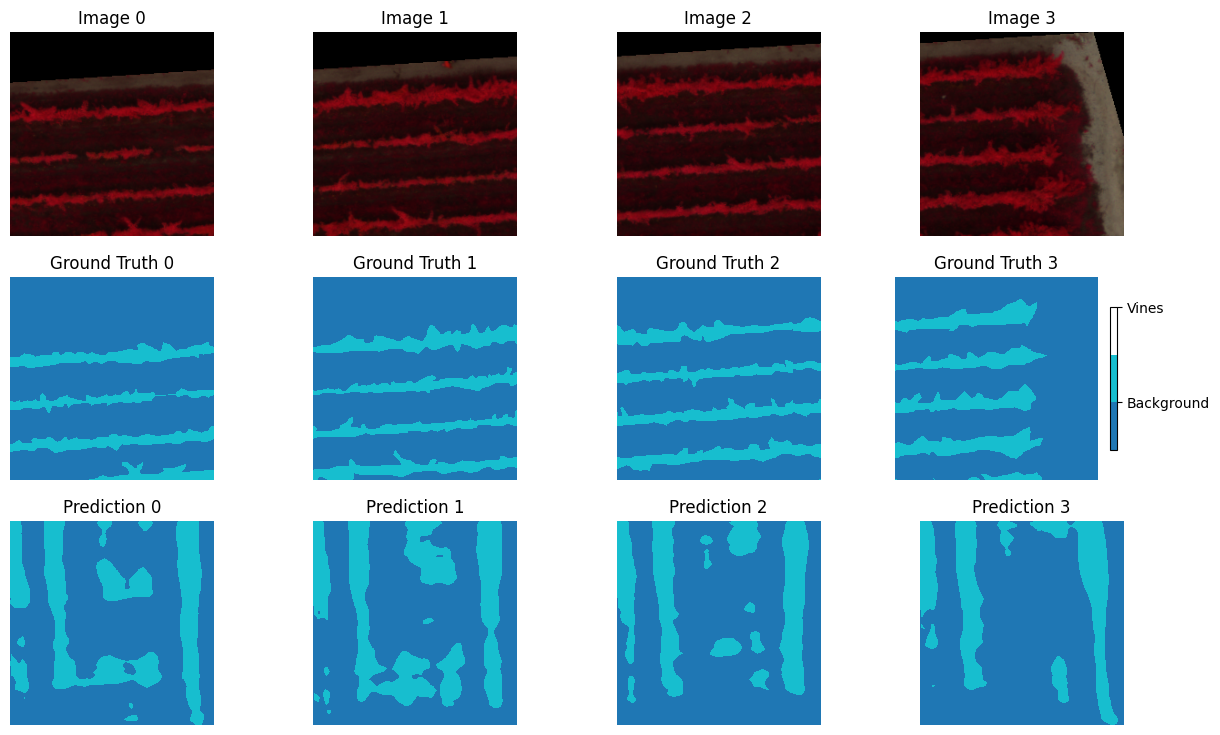

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.5912
Accuracy: 0.7256
Total F1 Score (micro-avg): 0.7256
Mean IoU: 0.4227

Per-class metrics:
Background:
  Precision: 0.9460
  Recall: 0.7439
  F1 Score: 0.8327
  IoU: 0.7136
Vines:
  Precision: 0.1507
  Recall: 0.5144
  F1 Score: 0.2323
  IoU: 0.1318

Confusion Matrix:
tensor([[5422952, 1863356],
        [ 309841,  331659]], device='cuda:0')


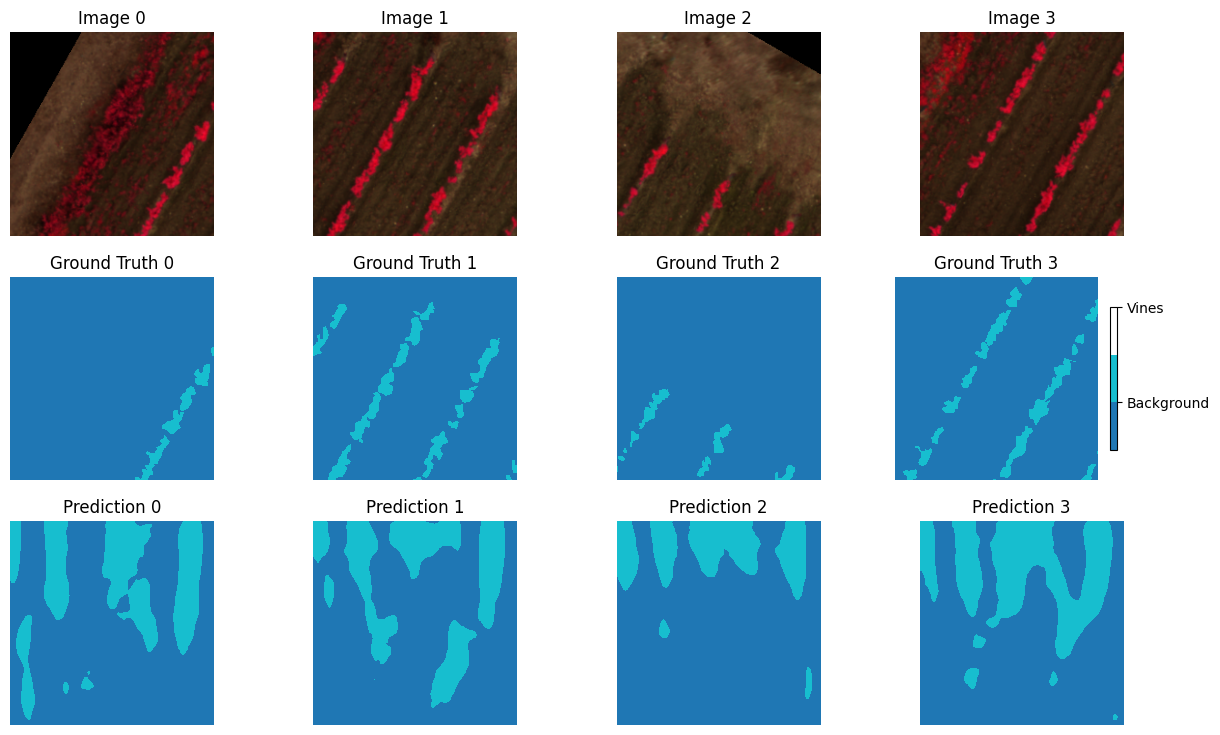

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.7011
Accuracy: 0.6511
Total F1 Score (micro-avg): 0.6511
Mean IoU: 0.3824

Per-class metrics:
Background:
  Precision: 0.8070
  Recall: 0.7444
  F1 Score: 0.7734
  IoU: 0.6310
Vines:
  Precision: 0.2078
  Recall: 0.2810
  F1 Score: 0.2349
  IoU: 0.1338

Confusion Matrix:
tensor([[4249985, 1460205],
        [1030318,  384484]], device='cuda:0')


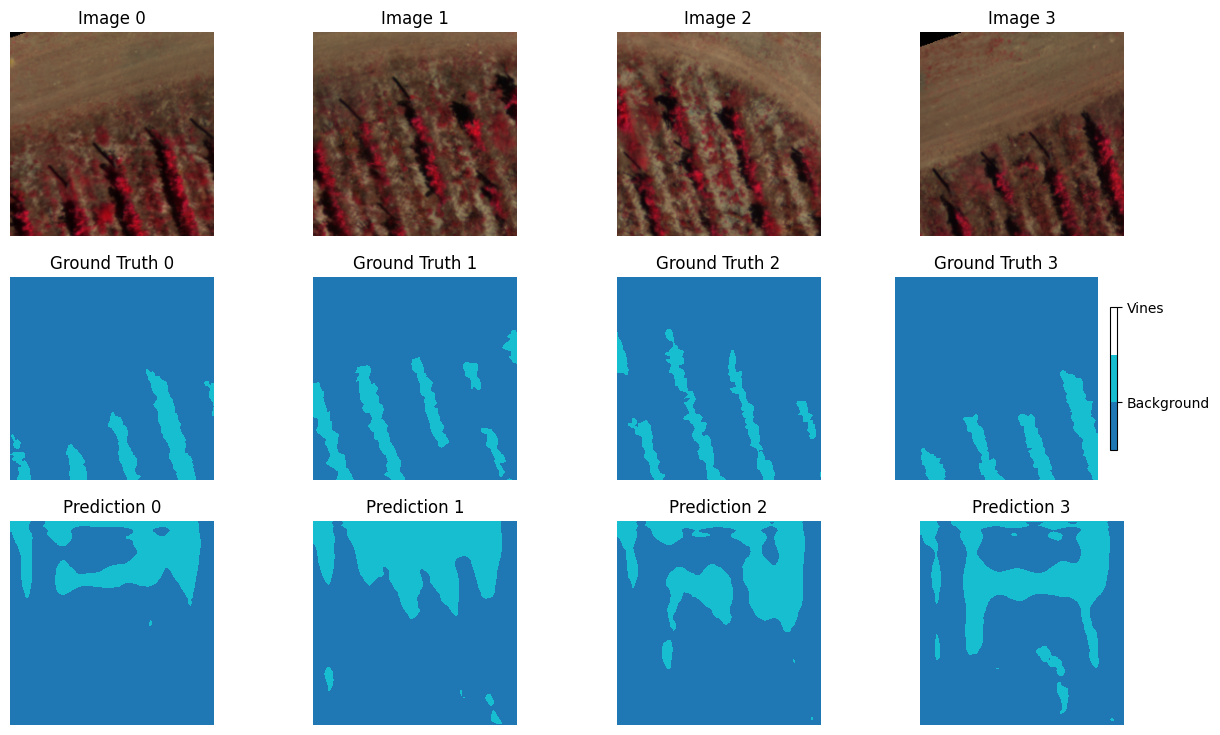

In [9]:
# Load the best model
device = "cuda"

best_model_path = checkpoint_callback.last_model_path
best_model = MeanTeacherSegmentationModel.load_from_checkpoint(best_model_path, 
                                                    backbone_type = "resnet18")

best_model.eval()

print(f"Loaded best model from {best_model_path}")

uber_test_results_e2 = best_model.test(val_loader)

visualize_predictions(
    model=best_model,
    dataloader=val_loader,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

uber_test_results_v = best_model.test(test_loader_v)


visualize_predictions(
    model=best_model,
    dataloader=test_loader_v,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

uber_test_results_q = best_model.test(test_loader_q)

visualize_predictions(
    model=best_model,
    dataloader=test_loader_q,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

In [73]:
# Save just the state dict for easier loading in production
model_state_dict_path = "segmentation_checkpoints/r50seg_all_best_state_dict.pth"
torch.save(best_model.state_dict(), model_state_dict_path)
print(f"Saved model state dict to {model_state_dict_path}")

Saved model state dict to segmentation_checkpoints/r50seg_all_best_state_dict.pth
